In [1]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
train = reduce_mem_usage(pd.read_csv('input/train.csv.zip'))
test = reduce_mem_usage(pd.read_csv('input/test.csv.zip'))
mulliken = reduce_mem_usage(pd.read_csv('input/mulliken_charges.csv.zip'))
dipole = reduce_mem_usage(pd.read_csv('input/dipole_moments.csv.zip'))
structure = reduce_mem_usage(pd.read_csv('input/structures.csv.zip'))
potential = reduce_mem_usage(pd.read_csv('input/potential_energy.csv.zip'))
magnetic = reduce_mem_usage(pd.read_csv('input/magnetic_shielding_tensors.csv.zip'))
scaler = reduce_mem_usage(pd.read_csv('input/scalar_coupling_contributions.csv.zip'))
sub = reduce_mem_usage(pd.read_csv('input/sample_submission.csv.zip'))


Mem. usage decreased to 106.62 Mb (50.0% reduction)
Mem. usage decreased to 52.57 Mb (45.0% reduction)
Mem. usage decreased to 16.09 Mb (54.2% reduction)
Mem. usage decreased to  1.13 Mb (56.2% reduction)
Mem. usage decreased to 51.74 Mb (52.1% reduction)
Mem. usage decreased to  0.81 Mb (37.5% reduction)
Mem. usage decreased to 39.49 Mb (69.3% reduction)
Mem. usage decreased to 115.50 Mb (59.4% reduction)
Mem. usage decreased to 11.95 Mb (68.7% reduction)


In [4]:
train.head(10)

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   
5   5  dsgdb9nsd_000001             2             3  2JHH   
6   6  dsgdb9nsd_000001             2             4  2JHH   
7   7  dsgdb9nsd_000001             3             0  1JHC   
8   8  dsgdb9nsd_000001             3             4  2JHH   
9   9  dsgdb9nsd_000001             4             0  1JHC   

   scalar_coupling_constant  
0                84.8125000  
1               -11.2578125  
2               -11.2578125  
3               -11.2578125  
4                84.8125000  
5               -11.2578125  
6               -11.2578125  
7                84.8125000  
8               -11.2578125  
9                84.8125000

In [5]:
structure.head(10)

molecule_name  atom_index atom                  x                  y  \
0  dsgdb9nsd_000001           0    C -0.012695312500000  1.085937500000000   
1  dsgdb9nsd_000001           1    H  0.002149581909180 -0.006031036376953   
2  dsgdb9nsd_000001           2    H  1.011718750000000  1.463867187500000   
3  dsgdb9nsd_000001           3    H -0.541015625000000  1.447265625000000   
4  dsgdb9nsd_000001           4    H -0.523925781250000  1.437500000000000   
5  dsgdb9nsd_000002           0    N -0.040435791015625  1.024414062500000   
6  dsgdb9nsd_000002           1    H  0.017257690429688  0.012542724609375   
7  dsgdb9nsd_000002           2    H  0.916015625000000  1.358398437500000   
8  dsgdb9nsd_000002           3    H -0.520507812500000  1.343750000000000   
9  dsgdb9nsd_000003           0    O -0.034362792968750  0.977539062500000   

                   z  
0  0.008003234863281  
1  0.001976013183594  
2  0.000276565551758  
3 -0.876464843750000  
4  0.906250000000000  
5  0.062561035156250  
6 -0.027374267578125  
7 -0.028762817382812  
8 -0.775390625000000  
9  0.007602691650391

In [6]:
magnetic.shape

(1533537, 11)

In [7]:
potential.head()

molecule_name  potential_energy
0  dsgdb9nsd_000001         -40.53125
1  dsgdb9nsd_000002         -56.56250
2  dsgdb9nsd_000003         -76.43750
3  dsgdb9nsd_000005         -93.43750
4  dsgdb9nsd_000007         -79.81250

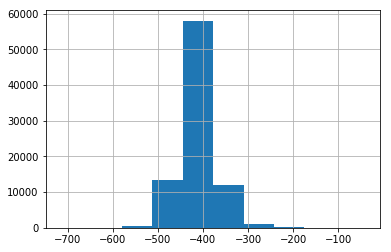

In [8]:
potential.potential_energy.hist()

In [9]:
magnetic.head()

molecule_name  atom_index          XX            YX                 ZX  \
0  dsgdb9nsd_000001           0  195.375000  0.0000000000 -0.000100016593933   
1  dsgdb9nsd_000001           1   31.343750 -1.2314453125  4.054687500000000   
2  dsgdb9nsd_000001           2   31.578125  1.2177734375 -4.148437500000000   
3  dsgdb9nsd_000001           3   31.515625  4.1093750000  1.272460937500000   
4  dsgdb9nsd_000001           4   31.406250 -4.0937500000 -1.179687500000000   

             XY          YY                 ZY                 XZ  \
0  0.0000000000  195.375000  0.000699996948242 -0.000100016593933   
1 -1.2314453125   28.953125 -1.717773437500000  4.054687500000000   
2  1.2177734375   28.906250 -1.603515625000000 -4.148437500000000   
3  4.1093750000   33.906250  1.695312500000000  1.272460937500000   
4 -4.0937500000   34.062500  1.625976562500000 -1.179687500000000   

                  YZ          ZZ  
0  0.000699996948242  195.375000  
1 -1.717773437500000   34.093750  
2 -1.603515625000000   33.906250  
3  1.695312500000000   28.953125  
4  1.625976562500000   28.906250

In [10]:
# train['scalar_coupling_constant'].apply(int).value_counts()

In [11]:
y = train['scalar_coupling_constant']

In [12]:
train = pd.read_csv('input/train_giba.csv', index_col=None)
test = pd.read_csv('input/test_giba.csv', index_col=None)

In [13]:
train.head(100)

molecule_name  atom_index_1  atom_index_0  id  type  \
0   dsgdb9nsd_000001             0             1   0  1JHC   
1   dsgdb9nsd_000001             2             1   1  2JHH   
2   dsgdb9nsd_000001             3             1   2  2JHH   
3   dsgdb9nsd_000001             4             1   3  2JHH   
4   dsgdb9nsd_000001             0             2   4  1JHC   
5   dsgdb9nsd_000001             3             2   5  2JHH   
6   dsgdb9nsd_000001             4             2   6  2JHH   
7   dsgdb9nsd_000001             0             3   7  1JHC   
8   dsgdb9nsd_000001             4             3   8  2JHH   
9   dsgdb9nsd_000001             0             4   9  1JHC   
10  dsgdb9nsd_000002             0             1  10  1JHN   
11  dsgdb9nsd_000002             2             1  11  2JHH   
12  dsgdb9nsd_000002             3             1  12  2JHH   
13  dsgdb9nsd_000002             0             2  13  1JHN   
14  dsgdb9nsd_000002             3             2  14  2JHH   
15  dsgdb9nsd_000002             0             3  15  1JHN   
16  dsgdb9nsd_000003             2             1  16  2JHH   
17  dsgdb9nsd_000005             0             2  17  1JHC   
18  dsgdb9nsd_000005             1             2  18  2JHN   
19  dsgdb9nsd_000007             0             2  19  1JHC   
20  dsgdb9nsd_000007             1             2  20  2JHC   
21  dsgdb9nsd_000007             3             2  21  2JHH   
22  dsgdb9nsd_000007             4             2  22  2JHH   
23  dsgdb9nsd_000007             5             2  23  3JHH   
24  dsgdb9nsd_000007             6             2  24  3JHH   
25  dsgdb9nsd_000007             7             2  25  3JHH   
26  dsgdb9nsd_000007             0             3  26  1JHC   
27  dsgdb9nsd_000007             1             3  27  2JHC   
28  dsgdb9nsd_000007             4             3  28  2JHH   
29  dsgdb9nsd_000007             5             3  29  3JHH   
..               ...           ...           ...  ..   ...   
70  dsgdb9nsd_000009             2             6  70  1JHC   
71  dsgdb9nsd_000010             0             3  71  1JHC   
72  dsgdb9nsd_000010             1             3  72  2JHC   
73  dsgdb9nsd_000010             2             3  73  3JHN   
74  dsgdb9nsd_000010             4             3  74  2JHH   
75  dsgdb9nsd_000010             5             3  75  2JHH   
76  dsgdb9nsd_000010             0             4  76  1JHC   
77  dsgdb9nsd_000010             1             4  77  2JHC   
78  dsgdb9nsd_000010             2             4  78  3JHN   
79  dsgdb9nsd_000010             5             4  79  2JHH   
80  dsgdb9nsd_000010             0             5  80  1JHC   
81  dsgdb9nsd_000010             1             5  81  2JHC   
82  dsgdb9nsd_000010             2             5  82  3JHN   
83  dsgdb9nsd_000011             0             3  83  1JHC   
84  dsgdb9nsd_000011             1             3  84  2JHC   
85  dsgdb9nsd_000011             4             3  85  2JHH   
86  dsgdb9nsd_000011             5             3  86  2JHH   
87  dsgdb9nsd_000011             6             3  87  3JHH   
88  dsgdb9nsd_000011             0             4  88  1JHC   
89  dsgdb9nsd_000011             1             4  89  2JHC   
90  dsgdb9nsd_000011             5             4  90  2JHH   
91  dsgdb9nsd_000011             6             4  91  3JHH   
92  dsgdb9nsd_000011             0             5  92  1JHC   
93  dsgdb9nsd_000011             1             5  93  2JHC   
94  dsgdb9nsd_000011             6             5  94  3JHH   
95  dsgdb9nsd_000011             0             6  95  2JHC   
96  dsgdb9nsd_000011             1             6  96  1JHC   
97  dsgdb9nsd_000012             0             3  97  1JHN   
98  dsgdb9nsd_000012             1             3  98  2JHC   
99  dsgdb9nsd_000012             4             3  99  2JHH   

    scalar_coupling_constant  ID structure_atom_0  structure_x_0  \
0         84.807599999999994   1                H   0.0021504160   
1        -11.2570000000000

In [14]:
np.unique(train['type'])

array(['1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN'],
      dtype=object)

In [15]:
def metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(metrics.mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)
#df for evaluate
eval_df = pd.DataFrame({"type": train["type"]})
eval_df["scalar_coupling_constant"] = y

In [16]:
train.head()

molecule_name  atom_index_1  atom_index_0  id  type  \
0  dsgdb9nsd_000001             0             1   0  1JHC   
1  dsgdb9nsd_000001             2             1   1  2JHH   
2  dsgdb9nsd_000001             3             1   2  2JHH   
3  dsgdb9nsd_000001             4             1   3  2JHH   
4  dsgdb9nsd_000001             0             2   4  1JHC   

   scalar_coupling_constant  ID structure_atom_0  structure_x_0  \
0        84.807599999999994   1                H    0.002150416   
1       -11.257000000000000   1                H    0.002150416   
2       -11.254799999999999   1                H    0.002150416   
3       -11.254300000000001   1                H    0.002150416   
4        84.807400000000001   1                H    1.011730843   

   structure_y_0  ...  adC4 adN1  adN2  adN3  adN4   NC  NH  NN  NF  NO  
0  -0.0060313176  ...   NaN  NaN   NaN   NaN   NaN  1.0   4 NaN NaN NaN  
1  -0.0060313176  ...   NaN  NaN   NaN   NaN   NaN  1.0   4 NaN NaN NaN  
2  -0.0060313176  ...   NaN  NaN   NaN   NaN   NaN  1.0   4 NaN NaN NaN  
3  -0.0060313176  ...   NaN  NaN   NaN   NaN   NaN  1.0   4 NaN NaN NaN  
4   1.4637511620  ...   NaN  NaN   NaN   NaN   NaN  1.0   4 NaN NaN NaN  

[5 rows x 91 columns]

In [17]:
train.shape

(4658147, 91)

In [ ]:
params = {'num_leaves': 100,
          'min_child_samples': 79,
          'objective': 'regression_l2',
          'max_depth': 15,
          'learning_rate': 0.07,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 1,
          'seed': 666,
          'colsample_bytree': .9
         }

In [37]:
for f in ['structure_atom_0', 'structure_atom_1', 'molecule_name.1']:
    train[f] = train[f].astype('category')
    test[f] = test[f].astype('category')

In [ ]:
test.shape

In [39]:
from catboost import Pool, CatBoostClassifier, CatBoostRegressor



In [40]:
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
n_split = 5
kf = KFold(n_splits=n_split, random_state=666, shuffle=True)
    
for type_ in np.unique(train['type']):

    
    train_ = train[train['type'] == type_]
    test_ = test[test['type'] == type_]
    
    train_index = train_.index
    test_index = test_.index
    
    y_ = y[train['type'] == type_]
    
    all_pos = np.sum(y_.apply(int).value_counts().index.values > 0)
    
#     if all_pos:
#         y_ = np.log1p(y_)
    
    all_pos = False
    
    
    features = [c for c in train_.columns if c not in ['id', 'molecule_name', 'x_0', 'y_0', 'z_0', 'ID',
                                                       'x_1', 'y_1', 'z_1', 'atom_index',
                                                       'type', 'scalar_coupling_constant',
                                                       'atom_0', 'atom_1', 'fc', 'sd', 'pso', 'dso']]
    for i, (train_idx, valid_idx) in enumerate(kf.split(train_)):  
        print(f'Fold {i + 1}')
        x_train = train_[features]
        y_train = y_
        trn_data = lgb.Dataset(x_train.iloc[train_idx], label=y_train.iloc[train_idx])
        val_data = lgb.Dataset(x_train.iloc[valid_idx], label=y_train.iloc[valid_idx])

        num_round = 3000
        clf = lgb.train(params, trn_data, num_round, valid_sets=[trn_data, val_data],
                        verbose_eval=500, early_stopping_rounds=50)
        if all_pos:
            oof[train_index[valid_idx]] = np.expm1(clf.predict(x_train.iloc[valid_idx], 
                                                               num_iteration=clf.best_iteration))

            predictions[test_index] += np.expm1(clf.predict(test_[features],
                                                            num_iteration=clf.best_iteration)) / n_split

        else:
            oof[train_index[valid_idx]] = clf.predict(x_train.iloc[valid_idx], num_iteration=clf.best_iteration)

            predictions[test_index] += clf.predict(test_[features], num_iteration=clf.best_iteration) / n_split

    
print("CV score: {:<8.5f}".format(metric(eval_df, oof)))

Fold 1
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 0.658546	valid_1's l1: 0.935407
[1000]	training's l1: 0.467723	valid_1's l1: 0.856778
[1500]	training's l1: 0.360119	valid_1's l1: 0.823476
[2000]	training's l1: 0.28764	valid_1's l1: 0.804865
[2500]	training's l1: 0.234544	valid_1's l1: 0.792879
[3000]	training's l1: 0.194158	valid_1's l1: 0.785111
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.194158	valid_1's l1: 0.785111
Fold 2
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 0.66007	valid_1's l1: 0.931112
[1000]	training's l1: 0.47007	valid_1's l1: 0.854209
[1500]	training's l1: 0.361295	valid_1's l1: 0.819988
[2000]	training's l1: 0.288476	valid_1's l1: 0.801264
[2500]	training's l1: 0.235151	valid_1's l1: 0.789175
[3000]	training's l1: 0.194668	valid_1's l1: 0.781328
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.194668	valid_1's l1: 0.781328
Fold 3
Training

[500]	training's l1: 0.118364	valid_1's l1: 0.207146
[1000]	training's l1: 0.074458	valid_1's l1: 0.193704
[1500]	training's l1: 0.0515521	valid_1's l1: 0.188893
[2000]	training's l1: 0.0372052	valid_1's l1: 0.186382
[2500]	training's l1: 0.027708	valid_1's l1: 0.185053
[3000]	training's l1: 0.0210409	valid_1's l1: 0.184243
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.0210409	valid_1's l1: 0.184243
Fold 5
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 0.118224	valid_1's l1: 0.207698
[1000]	training's l1: 0.0744937	valid_1's l1: 0.194775
[1500]	training's l1: 0.0515589	valid_1's l1: 0.19015
[2000]	training's l1: 0.0373163	valid_1's l1: 0.187775
[2500]	training's l1: 0.0278175	valid_1's l1: 0.186478
[3000]	training's l1: 0.0211795	valid_1's l1: 0.185706
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.0211795	valid_1's l1: 0.185706
Fold 1
Training until validation scores don't improve for 50 rounds.
[50

[3000]	training's l1: 0.0481527	valid_1's l1: 0.225423
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.0481527	valid_1's l1: 0.225423
Fold 1
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 0.0613255	valid_1's l1: 0.18299
[1000]	training's l1: 0.0274703	valid_1's l1: 0.176205
[1500]	training's l1: 0.0144037	valid_1's l1: 0.17439
[2000]	training's l1: 0.00833718	valid_1's l1: 0.173761
[2500]	training's l1: 0.0053071	valid_1's l1: 0.173496
[3000]	training's l1: 0.00370626	valid_1's l1: 0.173372
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.00370626	valid_1's l1: 0.173372
Fold 2
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 0.0611274	valid_1's l1: 0.178312
[1000]	training's l1: 0.027374	valid_1's l1: 0.171735
[1500]	training's l1: 0.0143368	valid_1's l1: 0.169951
[2000]	training's l1: 0.00829578	valid_1's l1: 0.169293
[2500]	training's l1: 0.0052672	valid_1's l1: 0.1690

In [47]:
predictions

array([ 18.78641041, 145.87447121,   2.17003317, ...,   1.35174067,
         5.91796059, 119.38095938])

In [48]:
test.shape

(2505542, 91)

In [49]:
sub = pd.read_csv('input/sample_submission.csv.zip')

In [50]:
sub.head()

id  scalar_coupling_constant
0  4658147                         0
1  4658148                         0
2  4658149                         0
3  4658150                         0
4  4658151                         0

In [45]:
sub.shape

(2505542, 2)

In [32]:
len(predictions)

2505542

In [33]:
sub['scalar_coupling_constant'] = predictions

sub.to_csv("submission-lgbm-v0.3.6.csv", index=False)

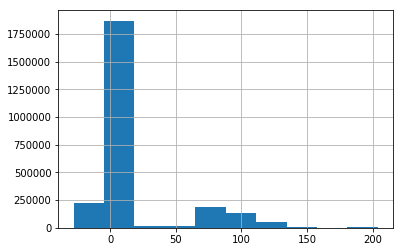

In [34]:
sub['scalar_coupling_constant'].hist()

In [52]:
pd.DataFrame(oof).to_csv('oofs/validation_lgbm_v0.3.6-0.csv', index=False)
pd.DataFrame(predictions).to_csv('oofs/test_lgbm_v0.3.6-0.csv', index=False)

In [55]:
# ! rm oofs/test_lgbm_v0.3-0.6.csv